In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing
data_paths = {}
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Installing Pyspark

In [ ]:
!pip install pyspark

### Using Spark in Python
The first step in using Spark is connecting to a cluster.

In practice, the cluster will be hosted on a remote machine that's connected to all other nodes. There will be one computer, called the master that manages splitting up the data and the computations. The master is connected to the rest of the computers in the cluster, which are called worker. The master sends the workers data and calculations to run, and they send their results back to the master.

When you're just getting started with Spark it's simpler to just run a cluster locally. Thus, for this course, instead of connecting to another computer, all computations will be run on DataCamp's servers in a simulated cluster.

Creating the connection is as simple as creating an instance of the SparkContext class. The class constructor takes a few optional arguments that allow you to specify the attributes of the cluster you're connecting to.

An object holding all these attributes can be created with the SparkConf() constructor. Take a look at the documentation for all the details!

In [ ]:
from pyspark import SparkContext, SparkConf
sc = SparkContext('local')
print(sc.version)

### Using Spark DataFrames
Spark's core data structure is the Resilient Distributed Dataset (RDD). This is a low level object that lets Spark work its magic by splitting data across multiple nodes in the cluster. However, RDDs are hard to work with directly, so in this course you'll be using the Spark DataFrame abstraction built on top of RDDs.

The Spark DataFrame was designed to behave a lot like a SQL table (a table with variables in the columns and observations in the rows). Not only are they easier to understand, DataFrames are also more optimized for complicated operations than RDDs.

When you start modifying and combining columns and rows of data, there are many ways to arrive at the same result, but some often take much longer than others. When using RDDs, it's up to the data scientist to figure out the right way to optimize the query, but the DataFrame implementation has much of this optimization built in!

To start working with Spark DataFrames, you first have to create a SparkSession object from your SparkContext. You can think of the SparkContext as your connection to the cluster and the SparkSession as your interface with that connection.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Print my_spark
print(spark)

### Viewing tables
Once you've created a SparkSession, you can start poking around to see what data is in your cluster!

Your SparkSession has an attribute called catalog which lists all the data inside the cluster. This attribute has a few methods for extracting different pieces of information.

One of the most useful is the .listTables() method, which returns the names of all the tables in your cluster as a list.

In [ ]:
# Print the tables in the catalog
print(spark.catalog.listTables())

### Put some Spark in your data
put a pandas DataFrame into a Spark cluster! The SparkSession class has a method for this as well.

The .createDataFrame() method takes a pandas DataFrame and returns a Spark DataFrame.

The output of this method is stored locally, not in the SparkSession catalog. This means that you can use all the Spark DataFrame methods on it, but you can't access the data in other contexts.

For example, a SQL query (using the .sql() method) that references your DataFrame will throw an error. To access the data in this way, you have to save it as a temporary table.

You can do this using the .createTempView() Spark DataFrame method, which takes as its only argument the name of the temporary table you'd like to register. This method registers the DataFrame as a table in the catalog, but as this table is temporary, it can only be accessed from the specific SparkSession used to create the Spark DataFrame.

There is also the method .createOrReplaceTempView(). This safely creates a new temporary table if nothing was there before, or updates an existing table if one was already defined. You'll use this method to avoid running into problems with duplicate tables.

Check out the diagram to see all the different ways your Spark data structures interact with each other.

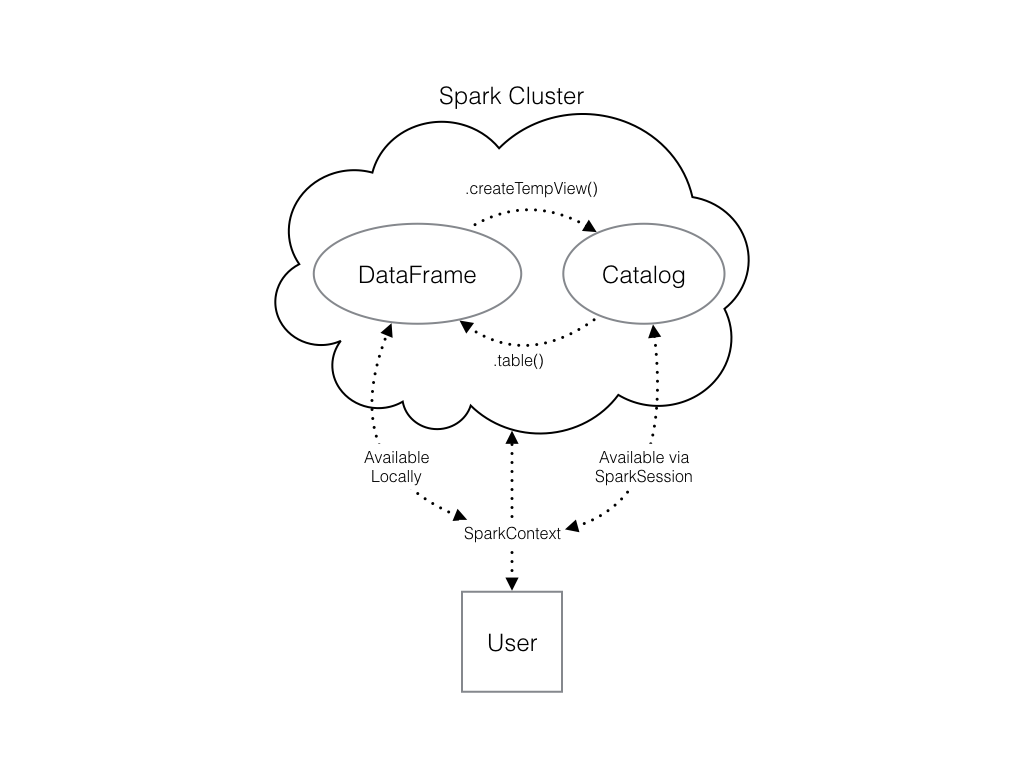

In [ ]:
# Create pd_temp
pd_temp = pd.DataFrame(np.random.random(10))

# Create spark_temp from pd_temp
spark_temp = spark.createDataFrame(pd_temp)

# Examine the tables in the catalog
print(spark.catalog.listTables())

# Add spark_temp to the catalog
spark_temp.createOrReplaceTempView('temp')

# Examine the tables in the catalog again
print(spark.catalog.listTables())

### Dropping the middle man
Now you know how to put data into Spark via pandas, but you're probably wondering why deal with pandas at all? Wouldn't it be easier to just read a text file straight into Spark? Of course it would!

Luckily, your SparkSession has a .read attribute which has several methods for reading different data sources into Spark DataFrames. Using these you can create a DataFrame from a .csv file just like with regular pandas DataFrames!

The variable file_path is a string with the path to the file airports.csv. This file contains information about different airports all over the world.

In [ ]:
# Read in the airports data
airports = spark.read.csv(data_paths['airports.csv'], header = True)

# Show the data
airports.show(10)

In [ ]:
# Read in the airports data
flights = spark.read.csv(data_paths['flights.csv'], header = True)

# Show the data shape
print((flights.count(), len(flights.columns)))

# print the tables in catalog
print(spark.catalog.listTables())

# adding data into spark view for sql querying
flights.createOrReplaceTempView('flights')

# print the tables in catalog
print(spark.catalog.listTables())

In [ ]:
# see all columns in the table 
print(flights.columns)

In [ ]:
# Don't change this query
query = "SELECT AIRLINE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE FROM flights LIMIT 5"

# Get the first 10 rows of flights
flights5 = spark.sql(query)

# Show the results
flights5.show()

In [ ]:
# Don't change this query
query = "SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT, COUNT(*) as N FROM flights GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT"

# Run the query
flight_counts = spark.sql(query)

# Convert the results to a pandas DataFrame
pd_counts = flight_counts.toPandas()

# Print the head of pd_counts
print(pd_counts.head())

### Creating columns
In this chapter, you'll learn how to use the methods defined by Spark's DataFrame class to perform common data operations.

Let's look at performing column-wise operations. In Spark you can do this using the .withColumn() method, which takes two arguments. First, a string with the name of your new column, and second the new column itself.

The new column must be an object of class Column. Creating one of these is as easy as extracting a column from your DataFrame using df.colName.

Updating a Spark DataFrame is somewhat different than working in pandas because the Spark DataFrame is immutable. This means that it can't be changed, and so columns can't be updated in place.

Thus, all these methods return a new DataFrame. To overwrite the original DataFrame you must reassign the returned DataFrame using the method like so:

```df = df.withColumn("newCol", df.oldCol + 1)```

The above code creates a DataFrame with the same columns as df plus a new column, newCol, where every entry is equal to the corresponding entry from oldCol, plus one.

To overwrite an existing column, just pass the name of the column as the first argument!

In [ ]:
# Create the DataFrame flights
flights = spark.table("flights")

# Add duration_hrs
flights = flights.withColumn('duration_hrs', flights.AIR_TIME/60.)

# Show the head
flights.select('duration_hrs').show(10)

### SQL in a nutshell
As you move forward, it will help to have a basic understanding of SQL. A more in depth look can be found here.

A SQL query returns a table derived from one or more tables contained in a database.

Every SQL query is made up of commands that tell the database what you want to do with the data. The two commands that every query has to contain are SELECT and FROM.

The SELECT command is followed by the columns you want in the resulting table.

The FROM command is followed by the name of the table that contains those columns. The minimal SQL query is:

```SELECT * FROM my_table;
The * selects all columns, so this returns the entire table named my_table.```

Similar to .withColumn(), you can do column-wise computations within a SELECT statement. For example,

```SELECT origin, dest, air_time / 60 FROM flights;```

returns a table with the origin, destination, and duration in hours for each flight.

Another commonly used command is WHERE. This command filters the rows of the table based on some logical condition you specify. The resulting table contains the rows where your condition is true. For example, if you had a table of students and grades you could do:

```SELECT * FROM students
WHERE grade = 'A';```

to select all the columns and the rows containing information about students who got As.

### SQL in a nutshell (2)
Another common database task is aggregation. That is, reducing your data by breaking it into chunks and summarizing each chunk.

This is done in SQL using the GROUP BY command. This command breaks your data into groups and applies a function from your SELECT statement to each group.

For example, if you wanted to count the number of flights from each of two origin destinations, you could use the query

```SELECT COUNT(*) FROM flights
GROUP BY origin;```

GROUP BY origin tells SQL that you want the output to have a row for each unique value of the origin column. The SELECT statement selects the values you want to populate each of the columns. Here, we want to COUNT() every row in each of the groups.

It's possible to GROUP BY more than one column. When you do this, the resulting table has a row for every combination of the unique values in each column. The following query counts the number of flights from SEA and PDX to every destination airport:

```SELECT origin, dest, COUNT(*) FROM flights
GROUP BY origin, dest;```

The output will have a row for every combination of the values in origin and dest (i.e. a row listing each origin and destination that a flight flew to). There will also be a column with the COUNT() of all the rows in each group.

Remember, a more in depth look at SQL can be found on sqlbolt.

Filtering Data
Now that you have a bit of SQL know-how under your belt, it's easier to talk about the analogous operations using Spark DataFrames.

Let's take a look at the .filter() method. As you might suspect, this is the Spark counterpart of SQL's WHERE clause. The .filter() method takes either an expression that would follow the WHERE clause of a SQL expression as a string, or a Spark Column of boolean (True/False) values.

For example, the following two expressions will produce the same output:

```flights.filter("air_time > 120").show()
flights.filter(flights.air_time > 120).show()```

Notice that in the first case, we pass a string to .filter(). In SQL, we would write this filtering task as ```SELECT * FROM flights WHERE air_time > 120.```

Spark's .filter() can accept any expression that could go in the WHEREclause of a SQL query (in this case, "air_time > 120"), as long as it is passed as a string. Notice that in this case, we do not reference the name of the table in the string -- as we wouldn't in the SQL request.

In the second case, we actually pass a column of boolean values to .filter(). Remember that flights.air_time > 120 returns a column of boolean values that has True in place of those records in flights.air_time that are over 120, and False otherwise.

In [ ]:
# Filter flights by passing a string
long_flights1 = flights.filter("DISTANCE > 1000")

# Filter flights by passing a column of boolean values
long_flights2 = flights.filter(flights.DISTANCE > 1000)

### Selecting

The Spark variant of SQL's SELECT is the .select() method. This method takes multiple arguments - one for each column you want to select. These arguments can either be the column name as a string (one for each column) or a column object (using the df.colName syntax). When you pass a column object, you can perform operations like addition or subtraction on the column to change the data contained in it, much like inside .withColumn().

The difference between .select() and .withColumn() methods is that .select() returns only the columns you specify, while .withColumn() returns all the columns of the DataFrame in addition to the one you defined. It's often a good idea to drop columns you don't need at the beginning of an operation so that you're not dragging around extra data as you're wrangling. In this case, you would use .select() and not .withColumn().

In [ ]:
# Select the first set of columns
selected1 = flights.select('TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',)

# Select the second set of columns
temp = flights.select(flights.ORIGIN_AIRPORT, flights.DESTINATION_AIRPORT, flights.AIRLINE)

temp.show()

In [ ]:
# Define first filter
filterA = flights.ORIGIN_AIRPORT == "SEA"

# Define second filter
filterB = flights.DESTINATION_AIRPORT == "PDX"

# Filter the data, first by filterA then by filterB
selected2 = temp.filter(filterA).filter(filterB)

### Selecting II
Similar to SQL, you can also use the .select() method to perform column-wise operations. When you're selecting a column using the df.colName notation, 
you can perform any column operation and the .select() method will return the transformed column. For example,

`flights.select(flights.air_time/60)`

returns a column of flight durations in hours instead of minutes. You can also use the .alias() method to rename a column you're selecting. 
So if you wanted to .select() the column duration_hrs (which isn't in your DataFrame) you could do


`flights.select((flights.air_time/60).alias("duration_hrs"))`

The equivalent Spark DataFrame method .selectExpr() takes SQL expressions as a string:

`flights.selectExpr("air_time/60 as duration_hrs")`

with the SQL as keyword being equivalent to the .alias() method. To select multiple columns, you can pass multiple strings.

Remember, a SparkSession called spark is already in your workspace, along with the Spark DataFrame flights.

In [ ]:
# Define avg_speed
avg_speed = (flights.DISTANCE/(flights.AIR_TIME/60)).alias("avg_speed")

# Select the correct columns
speed1 = flights.select('TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', avg_speed)

# Create the same table using a SQL expression
speed2 = flights.selectExpr('TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', "DISTANCE/(AIR_TIME/60) as avg_speed")

### Data types
it's important to know that Aggregations on Tables & Modelling on data can be used only on numeric data. That means all of the columns in your DataFrame must be either integers or decimals (called 'doubles' in Spark).

When we imported our data, we let Spark guess what kind of information each column held. Unfortunately, Spark doesn't always guess right and you can see that some of the columns in our DataFrame are strings containing numbers as opposed to actual numeric values.

To remedy this, you can use the .cast() method in combination with the .withColumn() method. It's important to note that .cast() works on columns, while .withColumn() works on DataFrames.

The only argument you need to pass to .cast() is the kind of value you want to create, in string form. For example, to create integers, you'll pass the argument "integer" and for decimal numbers you'll use "double".

You can put this call to .cast() inside a call to .withColumn() to overwrite the already existing column, just like you did in the previous chapter!

In [ ]:
# Cast the columns to integers
flights = flights.withColumn("MONTH", flights.MONTH.cast("integer"))
flights = flights.withColumn("DAY_OF_WEEK", flights.DAY_OF_WEEK.cast("integer"))
flights = flights.withColumn("AIR_TIME", flights.AIR_TIME.cast("integer"))
flights = flights.withColumn("DISTANCE", flights.DISTANCE.cast("double"))
flights = flights.withColumn("ARRIVAL_DELAY", flights.ARRIVAL_DELAY.cast("integer"))

### Aggregating
All of the common aggregation methods, like `.min(), .max(), and .count()` are GroupedData methods. 

These are created by calling the .groupBy() DataFrame method. You'll learn exactly what that means in a few exercises. 
For now, all you have to do to use these functions is call that method on your DataFrame. 
For example, to find the minimum value of a column, col, in a DataFrame, df, you could do

`df.groupBy().min("col").show()`

This creates a GroupedData object (so you can use the .min() method), then finds the minimum value in col, and returns it as a DataFrame.

Now you're ready to do some aggregating of your own!

In [ ]:
# Find the shortest flight from PDX in terms of distance
flights.filter(flights.ORIGIN_AIRPORT == 'PDX').groupBy().min('DISTANCE').show()

# Find the longest flight from SEA in terms of air time
flights.filter(flights.ORIGIN_AIRPORT == 'SEA').groupBy().max('AIR_TIME').show()

In [ ]:
# Group by tailnum
by_plane = flights.groupBy("TAIL_NUMBER")

# Number of flights each plane made
by_plane.count().show(10)

# Group by origin
by_origin = flights.groupBy("ORIGIN_AIRPORT")

# Average duration of flights from PDX and SEA
by_origin.avg("AIR_TIME").show(10)

### Aggregating II
In addition to the GroupedData methods you've already seen, there is also the .agg() method. 
This method lets you pass an aggregate column expression that uses any of the aggregate functions from the pyspark.sql.functions submodule.

This submodule contains many useful functions for computing things like standard deviations. All the aggregation functions in this submodule take the name of a column in a GroupedData table.

In [ ]:
# Import pyspark.sql.functions as F
import pyspark.sql.functions as F

# cast
flights = flights.withColumn("DEPARTURE_DELAY", flights.DEPARTURE_DELAY.cast("integer"))

# Group by month and dest
by_month_dest = flights.groupBy('MONTH', 'DESTINATION_AIRPORT')

# Average departure delay by month and destination
by_month_dest.avg('DEPARTURE_DELAY').show(10)

# Standard deviation of departure delay
by_month_dest.agg(F.stddev('DEPARTURE_DELAY')).show(10)

### Joining

Another very common data operation is the join. Joins are a whole topic unto themselves, so in this course we'll just look at simple joins. 
If you'd like to learn more about joins, you can take a look here.

A join will combine two different tables along a column that they share. This column is called the key. 
Examples of keys here include the tailnum and airline columns from the flights table.

For example, suppose that you want to know more information about the plane that flew a flight than just the tail number. 
This information isn't in the flights table because the same plane flies many different flights over the course of two years, 
so including this information in every row would result in a lot of duplication. 

To avoid this, you'd have a second table that has only one row for each plane and whose columns list all the information about the plane, 
including its tail number. You could call this table planes

When you join the flights table to this table of airplane information, you're adding all the columns from the planes table to the flights table.
To fill these columns with information, you'll look at the tail number from the flights table and 
find the matching one in the planes table, and then use that row to fill out all the new columns.

Now you'll have a much bigger table than before, but now every row has all information about the plane that flew that flight!

In [ ]:
print(airports.columns)

# Examine the data
print(airports.show(10))

In [ ]:
# Rename the faa column
airports = airports.withColumnRenamed("IATA_CODE", "DESTINATION_AIRPORT")

# Join the DataFrames
flights_with_airports = flights.join(airports , on = 'DESTINATION_AIRPORT', how = 'leftouter')

# Examine the new DataFrame
print(flights_with_airports.columns)
print(flights_with_airports.count())

In [ ]:
flights_with_airports.select('FLIGHT_NUMBER', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE').show(10)

In [ ]:
# Read in the airports data
airlines = spark.read.csv(data_paths['airlines.csv'], header = True)

# Show the data shape
print((airlines.count(), len(airlines.columns)))

airlines.show()

### Machine Learning Pipelines to Predict the Flights Delay
In the next two chapters you'll step through every stage of the machine learning pipeline, from data intake to model evaluation. Let's get to it!

At the core of the pyspark.ml module are the Transformer and Estimator classes. Almost every other class in the module behaves similarly to these two basic classes.

Transformer classes have a .transform() method that takes a DataFrame and returns a new DataFrame; usually the original one with a new column appended. For example, you might use the class Bucketizer to create discrete bins from a continuous feature or the class PCA to reduce the dimensionality of your dataset using principal component analysis.

Estimator classes all implement a .fit() method. These methods also take a DataFrame, but instead of returning another DataFrame they return a model object. This can be something like a StringIndexerModel for including categorical data saved as strings in your models, or a RandomForestModel that uses the random forest algorithm for classification or regression.

In [ ]:
# filtering columns
model_data = flights.select('MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'TAIL_NUMBER', 'DESTINATION_AIRPORT', 'AIR_TIME', 'DISTANCE', 'ARRIVAL_DELAY',)

# Remove missing values
model_data = model_data.filter("ARRIVAL_DELAY is not NULL and AIRLINE is not NULL and AIR_TIME is not NULL and TAIL_NUMBER is not NULL")

# rows left
model_data.count()

In [ ]:
# Create is_late (label)
model_data = model_data.withColumn("is_late", model_data.ARRIVAL_DELAY > 0)

# cast
model_data = model_data.withColumn("is_late", model_data.is_late.cast("integer"))

# rename column
model_data = model_data.withColumnRenamed("is_late", 'label')

In [ ]:
model_data.show(15)

In [ ]:
print('Labels distrubution:')
model_data.groupBy('label').count().show()

### Strings and factors
As you know, Spark requires numeric data for modeling. So far this hasn't been an issue; even boolean columns can easily be converted to integers without any trouble. But you'll also be using the airline and the plane's destination as features in your model. These are coded as strings and there isn't any obvious way to convert them to a numeric data type.

Fortunately, PySpark has functions for handling this built into the pyspark.ml.features submodule. You can create what are called 'one-hot vectors' to represent the carrier and the destination of each flight. A one-hot vector is a way of representing a categorical feature where every observation has a vector in which all elements are zero except for at most one element, which has a value of one (1).

Each element in the vector corresponds to a level of the feature, so it's possible to tell what the right level is by seeing which element of the vector is equal to one (1).

The first step to encoding your categorical feature is to create a StringIndexer. Members of this class are Estimators that take a DataFrame with a column of strings and map each unique string to a number. Then, the Estimator returns a Transformer that takes a DataFrame, attaches the mapping to it as metadata, and returns a new DataFrame with a numeric column corresponding to the string column.

The second step is to encode this numeric column as a one-hot vector using a OneHotEncoder. This works exactly the same way as the StringIndexer by creating an Estimator and then a Transformer. The end result is a column that encodes your categorical feature as a vector that's suitable for machine learning routines!

This may seem complicated, but don't worry! All you have to remember is that you need to create a StringIndexer and a OneHotEncoder, and the Pipeline will take care of the rest.

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# Create a StringIndexer
airline_indexer = StringIndexer(inputCol="AIRLINE", outputCol="airline_index")

# Create a OneHotEncoder
airline_encoder = OneHotEncoder(inputCol="airline_index", outputCol="airline_fact")

In [ ]:
# Create a StringIndexer
dest_indexer = StringIndexer(inputCol="DESTINATION_AIRPORT", outputCol="dest_index")

# Create a OneHotEncoder
dest_encoder = OneHotEncoder(inputCol="dest_index", outputCol="dest_fact")

In [ ]:
# Create a StringIndexer
tail_indexer = StringIndexer(inputCol="TAIL_NUMBER", outputCol="tail_index")

# Create a OneHotEncoder
tail_encoder = OneHotEncoder(inputCol="tail_index", outputCol="tail_fact")

### Assemble a vector
The last step in the Pipeline is to combine all of the columns containing our features into a single column. This has to be done before modeling can take place because every Spark modeling routine expects the data to be in this form. You can do this by storing each of the values from a column as an entry in a vector. Then, from the model's point of view, every observation is a vector that contains all of the information about it and a label that tells the modeler what value that observation corresponds to.

Because of this, the pyspark.ml.feature submodule contains a class called VectorAssembler. This Transformer takes all of the columns you specify and combines them into a new vector column.

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Make a VectorAssembler of 'MONTH', 'DAY_OF_WEEK', 'AIR_TIME', 'DISTANCE', 'ARRIVAL_DELAY','AIRLINE', 'TAIL_NUMBER', 'DESTINATION_AIRPORT'
vec_assembler = VectorAssembler(inputCols=["MONTH", "DAY_OF_WEEK", "AIR_TIME", "DISTANCE", "airline_fact", "dest_fact", "tail_fact"], outputCol="features")

### Create the pipeline
You're finally ready to create a Pipeline!

Pipeline is a class in the pyspark.ml module that combines all the Estimators and Transformers that you've already created. This lets you reuse the same modeling process over and over again by wrapping it up in one simple object. Neat, right?

In [ ]:
# Import Pipeline
from pyspark.ml import Pipeline

# Make the pipeline
flights_pipe = Pipeline(stages=[dest_indexer, dest_encoder, airline_indexer, airline_encoder, tail_indexer, tail_encoder, vec_assembler])

In [ ]:
piped_data = flights_pipe.fit(model_data).transform(model_data)

In [ ]:
train_data, test_data = piped_data.randomSplit([.7, .3])

In [ ]:
print('data points(rows) in train data :',  train_data.count())
print('data points(rows) in train data :',  test_data.count())

### Create the model
The Estimator you'll be using is a LogisticRegression from the pyspark.ml.classification submodule.

In [ ]:
# Import LogisticRegression
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression Estimator
lr = LogisticRegression()

### Cross validation
In the next few exercises you'll be tuning your logistic regression model using a procedure called k-fold cross validation. This is a method of estimating the model's performance on unseen data (like your test DataFrame).

It works by splitting the training data into a few different partitions. The exact number is up to you, but in this course you'll be using PySpark's default value of three. Once the data is split up, one of the partitions is set aside, and the model is fit to the others. Then the error is measured against the held out partition. This is repeated for each of the partitions, so that every block of data is held out and used as a test set exactly once. Then the error on each of the partitions is averaged. This is called the cross validation error of the model, and is a good estimate of the actual error on the held out data.

You'll be using cross validation to choose the hyperparameters by creating a grid of the possible pairs of values for the two hyperparameters, elasticNetParam and regParam, and using the cross validation error to compare all the different models so you can choose the best one!

In [ ]:
# Import the evaluation submodule
import pyspark.ml.evaluation as evals

# Create a BinaryClassificationEvaluator
evaluator = evals.BinaryClassificationEvaluator(metricName="areaUnderROC")

### Make a grid
Next, you need to create a grid of values to search over when looking for the optimal hyperparameters. The submodule pyspark.ml.tuning includes a class called ParamGridBuilder that does just that (maybe you're starting to notice a pattern here; PySpark has a submodule for just about everything!).

You'll need to use the .addGrid() and .build() methods to create a grid that you can use for cross validation. The .addGrid() method takes a model parameter (an attribute of the model Estimator, lr, that you created a few exercises ago) and a list of values that you want to try. The .build() method takes no arguments, it just returns the grid that you'll use later.

In [ ]:
# Import the tuning submodule
import pyspark.ml.tuning as tune

# Create the parameter grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter
grid = grid.addGrid(lr.regParam, np.arange(0, .1, .01))
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid
grid = grid.build()

### Make the validator
The submodule pyspark.ml.tuning also has a class called CrossValidator for performing cross validation. This Estimator takes the modeler you want to fit, the grid of hyperparameters you created, and the evaluator you want to use to compare your models.

The submodule pyspark.ml.tune has already been imported as tune. You'll create the CrossValidator by passing it the logistic regression Estimator lr, the parameter grid, and the evaluator you created in the previous exercises.

In [ ]:
# Create the CrossValidator
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator)

### Fit the model(s)
You're finally ready to fit the models and select the best one!

Unfortunately, cross validation is a very computationally intensive procedure. Fitting all the models would take too long on DataCamp.

To do this locally you would use the code:

#### Fit cross validation models
`models = cv.fit(training)`

#### Extract the best model
`best_lr = models.bestModel`

Remember, the training data is called training and you're using lr to fit a logistic regression model. Cross validation selected the parameter values regParam=0 and elasticNetParam=0 as being the best. These are the default values, so you don't need to do anything else with lr before fitting the model.

In [ ]:
# Call lr.fit()
best_lr = lr.fit(train_data)

# Print best_lr
print(best_lr)

In [ ]:
# Use the model to predict the test set
test_results = best_lr.transform(test_data)

# Evaluate the predictions
print(evaluator.evaluate(test_results))

### ---------- END ------------